In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import hiplot as hip
import plotly.express as px
from sklearn.cluster import DBSCAN

In [3]:
component_columns = [
    "Attack ID", "Detect count", "Card", "Victim IP", "Port number",
    "Attack code", "Significant flag", "Packet speed", "Data speed",
    "Avg packet len", "Source IP count", "Time"
]

# Events
event_columns = [
    "Attack ID", "Card", "Victim IP", "Port number", "Attack code",
    "Detect count", "Significant flag", "Packet speed", "Data speed",
    "Avg packet len", "Avg source IP count", "Start time", "End time", "Whitelist flag", "Type"
]

df_A_components = pd.read_csv("../datasets/SCLDDoS2024_SetA_components.csv")
df_A_events = pd.read_csv("../datasets/SCLDDoS2024_SetA_events.csv")

df_D_components = pd.read_csv("../datasets/SCLDDoS2024_SetD_components.csv")
df_D_events = pd.read_csv("../datasets/SCLDDoS2024_SetD_events.csv")

df_B_components = pd.read_csv("../datasets/SCLDDoS2024_SetB_components.csv", header=None, names=component_columns)
df_B_events = pd.read_csv("../datasets/SCLDDoS2024_SetB_events.csv", header=None, names=event_columns)

df_C_components = pd.read_csv("../datasets/SCLDDoS2024_SetC_components.csv", header=None, names=component_columns)
df_C_events = pd.read_csv("../datasets/SCLDDoS2024_SetC_events.csv", header=None, names=event_columns)

In [4]:
df_A_events = df_A_events.drop(df_A_events[df_A_events['End time']=="0"].index)
df_B_events = df_B_events.drop(df_B_events[df_B_events['End time']=="0"].index)
df_C_events = df_C_events.drop(df_C_events[df_C_events['End time']=="0"].index)
df_D_events = df_D_events.drop(df_D_events[df_D_events['End time']=="0"].index)

In [5]:
df_A_events['Avg packet len'] = df_A_events['Avg packet len'].replace(0, 1)
df_B_events['Avg packet len'] = df_B_events['Avg packet len'].replace(0, 1)
df_C_events['Avg packet len'] = df_C_events['Avg packet len'].replace(0, 1)
df_D_events['Avg packet len'] = df_D_events['Avg packet len'].replace(0, 1)

In [6]:
df_A_events['Start time']=pd.to_datetime(df_A_events['Start time'])
df_A_events['End time']=pd.to_datetime(df_A_events['End time'])
df_A_components['Time']=pd.to_datetime(df_A_components['Time'])
df_B_events['Start time']=pd.to_datetime(df_B_events['Start time'])
df_B_events['End time']=pd.to_datetime(df_B_events['End time'])
df_B_components['Time']=pd.to_datetime(df_B_components['Time'])
df_C_events['Start time']=pd.to_datetime(df_C_events['Start time'])
df_C_events['End time']=pd.to_datetime(df_C_events['End time'])
df_C_components['Time']=pd.to_datetime(df_C_components['Time'])
df_D_events['Start time']=pd.to_datetime(df_D_events['Start time'])
df_D_events['End time']=pd.to_datetime(df_D_events['End time'])
df_D_components['Time']=pd.to_datetime(df_D_components['Time'])

In [7]:
df_A_events = df_A_events.drop(columns=['Significant flag', 'Whitelist flag'])
df_A_components = df_A_components.drop(columns=['Significant flag'])
df_B_events = df_B_events.drop(columns=['Significant flag', 'Whitelist flag'])
df_B_components = df_B_components.drop(columns=['Significant flag'])
df_C_events = df_C_events.drop(columns=['Significant flag', 'Whitelist flag'])
df_C_components = df_C_components.drop(columns=['Significant flag'])
df_D_events = df_D_events.drop(columns=['Significant flag', 'Whitelist flag'])
df_D_components = df_D_components.drop(columns=['Significant flag'])

In [8]:
df_A_events = df_A_events.drop(columns=['Card'])
df_B_events = df_B_events.drop(columns=['Card'])
df_C_events = df_C_events.drop(columns=['Card'])
df_D_events = df_D_events.drop(columns=['Card'])

In [9]:
df_A_events['Duration']=(df_A_events['End time'] - df_A_events['Start time']).dt.total_seconds()
df_B_events['Duration']=(df_B_events['End time'] - df_B_events['Start time']).dt.total_seconds()
df_C_events['Duration']=(df_C_events['End time'] - df_C_events['Start time']).dt.total_seconds()
df_D_events['Duration']=(df_D_events['End time'] - df_D_events['Start time']).dt.total_seconds()

In [28]:
train_df = pd.concat([df_A_events, df_B_events])
val_df = df_C_events
features = [
    "Port number",
    "Detect count",  "Packet speed", "Data speed",
    "Avg packet len", "Avg source IP count", "Duration"
]

In [33]:
X_train = train_df[features]
X_test = val_df[features]
y_train = train_df["Type"]
y_test = val_df["Type"]

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [34]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9904
Precision: 0.8590630935363412
Recall: 0.7914437155297506


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
import optuna

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Dictionary to store results for final comparison
results = {}

# Function to evaluate model and store results
def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, data_type):
    # Train model
    model.fit(X_train_data, y_train_data)

    # Predict and evaluate
    y_pred = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred, average="macro")
    precision = precision_score(y_test_data, y_pred, average="macro")
    f1 = f1_score(y_test_data, y_pred, average="macro")
    conf_matrix = confusion_matrix(y_test_data, y_pred)

    # Print results
    print(f"{model_name} with {data_type}")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Store results
    results[f"{model_name} ({data_type})"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }

    return model, y_pred, conf_matrix
    

def plot_conf_matrix(cm, model_name, data_type, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} - {data_type}")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

In [36]:
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train, y_train, X_test, y_test,
    "CatBoost", "original data"
)

CatBoost with original data
Accuracy: 0.9904, Recall: 0.8059, Precision: 0.8625, F1-score: 0.8266
Confusion Matrix:
[[   510    517     28]
 [   158 125374    361]
 [    48    140   2864]]


In [37]:
ada_model = AdaBoostClassifier(random_state=42)
ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train, y_train, X_test, y_test,
    "AdaBoost", "original data"
)

AdaBoost with original data
Accuracy: 0.9851, Recall: 0.6395, Precision: 0.9070, F1-score: 0.6984
Confusion Matrix:
[[   185    860     10]
 [    21 125609    263]
 [    14    763   2275]]


In [43]:
def optimize_catboost(X_train, y_train, X_val, y_val):
    print("\n=== Optimizing CatBoost ===")
    
    def objective(trial):
        param = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
            'random_seed': 42
        }
        
        model = CatBoostClassifier(**param, verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        return f1
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    
    print("Best CatBoost parameters:", study.best_params)
    best_params = study.best_params
    best_params['verbose'] = 0
    best_params['random_seed'] = 42
    
    return CatBoostClassifier(**best_params)

# Optimize AdaBoost with Optuna
def optimize_adaboost(X_train, y_train, X_val, y_val):
    print("\n=== Optimizing AdaBoost ===")
    
    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'algorithm': 'SAMME', 
            'random_state': 42
        }
        
        model = AdaBoostClassifier(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        return f1
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    
    print("Best AdaBoost parameters:", study.best_params)
    best_params = study.best_params
    best_params['algorithm'] = 'SAMME'  # Ensure this is set
    best_params['random_state'] = 42
    
    return AdaBoostClassifier(**best_params)

# Optimize models
best_catboost = optimize_catboost(X_train, y_train, X_test, y_test)
# best_adaboost = optimize_adaboost(X_train, y_train, X_test, y_test)

# Evaluate optimized models
catboost_optimized, y_pred_cat_opt, conf_cat_opt = evaluate_model(
    best_catboost, X_train, y_train, X_test, y_test,
    "CatBoost (optimized)", "selected features"
)

adaboost_optimized, y_pred_ada_opt, conf_ada_opt = evaluate_model(
    best_adaboost, X_train, y_train, X_test, y_test,
    "AdaBoost (optimized)", "selected features"
)

[I 2025-05-11 17:05:28,334] A new study created in memory with name: no-name-59ecb7a3-e46e-49d5-9238-a7b0c9f17822



=== Optimizing CatBoost ===


[I 2025-05-11 17:06:01,042] Trial 0 finished with value: 0.7713423021857911 and parameters: {'iterations': 792, 'learning_rate': 0.036563426840645036, 'depth': 9, 'l2_leaf_reg': 6.733319402675561, 'border_count': 115, 'random_strength': 1.9894524728515495, 'bagging_temperature': 9.667984556153572}. Best is trial 0 with value: 0.7713423021857911.
[I 2025-05-11 17:06:12,190] Trial 1 finished with value: 0.7877898533612009 and parameters: {'iterations': 765, 'learning_rate': 0.0942713089426199, 'depth': 6, 'l2_leaf_reg': 4.647477989370966, 'border_count': 122, 'random_strength': 4.274691911870289, 'bagging_temperature': 6.650538752340045}. Best is trial 1 with value: 0.7877898533612009.
[I 2025-05-11 17:06:27,386] Trial 2 finished with value: 0.7773547965979208 and parameters: {'iterations': 261, 'learning_rate': 0.043507161715381944, 'depth': 10, 'l2_leaf_reg': 3.0713973815521034, 'border_count': 148, 'random_strength': 5.629534932321032, 'bagging_temperature': 5.394494682006022}. Best i

Best CatBoost parameters: {'iterations': 356, 'learning_rate': 0.10548260881222134, 'depth': 9, 'l2_leaf_reg': 1.3949534359392914, 'border_count': 247, 'random_strength': 6.079287844487288, 'bagging_temperature': 4.600809460132604}
CatBoost (optimized) with selected features
Accuracy: 0.9910, Recall: 0.7898, Precision: 0.8893, F1-score: 0.8260
Confusion Matrix:
[[   481    549     25]
 [    61 125552    280]
 [    81    175   2796]]


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (optimized) with selected features
Accuracy: 0.9836, Recall: 0.6149, Precision: 0.9024, F1-score: 0.6824
Confusion Matrix:
[[   185    861      9]
 [    26 125628    239]
 [    12    991   2049]]


In [38]:
catboost_optimized, y_pred_cat_opt, conf_cat_opt = evaluate_model(
    best_catboost, X_train, y_train, X_test, y_test,
    "CatBoost (optimized)", "selected features"
)

adaboost_optimized, y_pred_ada_opt, conf_ada_opt = evaluate_model(
    best_adaboost, X_train, y_train, X_test, y_test,
    "AdaBoost (optimized)", "selected features"
)

CatBoost (optimized) with selected features
Accuracy: 0.9896, Recall: 0.7888, Precision: 0.8552, F1-score: 0.8141
Confusion Matrix:
[[   497    525     33]
 [    97 125402    394]
 [   110    198   2744]]


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (optimized) with selected features
Accuracy: 0.9836, Recall: 0.6149, Precision: 0.9024, F1-score: 0.6824
Confusion Matrix:
[[   185    861      9]
 [    26 125628    239]
 [    12    991   2049]]


In [39]:
# Method 1: Simple Voting Classifier
def create_voting_ensemble(X_train_cat, X_train_ada, X_test_cat, X_test_ada, y_train, y_test):
    print("\n=== Creating Voting Ensemble ===")
    le= LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)
    # Train models on respective selected features
    best_catboost.fit(X_train_cat, y_train)
    best_adaboost.fit(X_train_ada, y_train)
    
    # Get predictions for both models
    cat_preds = best_catboost.predict_proba(X_test_cat)
    ada_preds = best_adaboost.predict_proba(X_test_ada)
    
    # Combine predictions (weighted average)
    # Adjust these weights based on model performance
    ensemble_preds = cat_preds * 0.7 + ada_preds * 0.3
    ensemble_classes = np.argmax(ensemble_preds, axis=1)
    
    # Evaluate ensemble
    accuracy = accuracy_score(y_test, ensemble_classes)
    recall = recall_score(y_test, ensemble_classes, average="macro")
    precision = precision_score(y_test, ensemble_classes, average="macro")
    f1 = f1_score(y_test, ensemble_classes, average="macro")
    conf_matrix = confusion_matrix(y_test, ensemble_classes)
    
    print("Voting Ensemble (weighted probabilities)")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Store results
    results["Voting Ensemble (weighted)"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }
    
    return ensemble_classes, conf_matrix

# Method 2: Stacking Ensemble with XGBoost as meta-learner
def create_stacking_ensemble(X_train_cat, X_train_ada, X_test_cat, X_test_ada, y_train, y_test):
    print("\n=== Creating Stacking Ensemble ===")
    le= LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)
    # Train base models
    best_catboost.fit(X_train_cat, y_train)
    best_adaboost.fit(X_train_ada, y_train)
    
    # Generate meta-features
    cat_train_preds = best_catboost.predict_proba(X_train_cat)
    ada_train_preds = best_adaboost.predict_proba(X_train_ada)
    
    # Combine meta-features
    meta_features_train = np.hstack([cat_train_preds, ada_train_preds])
    
    # Train meta-learner
    meta_learner = XGBClassifier(random_state=42)
    meta_learner.fit(meta_features_train, y_train)
    
    # Generate meta-features for test set
    cat_test_preds = best_catboost.predict_proba(X_test_cat)
    ada_test_preds = best_adaboost.predict_proba(X_test_ada)
    meta_features_test = np.hstack([cat_test_preds, ada_test_preds])
    
    # Make final predictions
    ensemble_classes = meta_learner.predict(meta_features_test)
    
    # Evaluate ensemble
    accuracy = accuracy_score(y_test, ensemble_classes)
    recall = recall_score(y_test, ensemble_classes, average="macro")
    precision = precision_score(y_test, ensemble_classes, average="macro")
    f1 = f1_score(y_test, ensemble_classes, average="macro")
    conf_matrix = confusion_matrix(y_test, ensemble_classes)
    
    print("Stacking Ensemble (XGBoost meta-learner)")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Store results
    results["Stacking Ensemble (XGBoost)"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }
    
    return ensemble_classes, conf_matrix, meta_learner

# Create ensemble models
voting_preds, voting_conf = create_voting_ensemble(
    X_train, X_train,
    X_test, X_test,
    y_train, y_test
)

stacking_preds, stacking_conf, meta_learner = create_stacking_ensemble(
    X_train, X_train,
    X_test, X_test,
    y_train, y_test
)



=== Creating Voting Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Voting Ensemble (weighted probabilities)
Accuracy: 0.9895, Recall: 0.7859, Precision: 0.8560, F1-score: 0.8125
Confusion Matrix:
[[   491    532     32]
 [    94 125406    393]
 [   108    209   2735]]

=== Creating Stacking Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Stacking Ensemble (XGBoost meta-learner)
Accuracy: 0.9882, Recall: 0.7941, Precision: 0.8242, F1-score: 0.8053
Confusion Matrix:
[[   517    506     32]
 [   181 125203    509]
 [   106    206   2740]]


In [41]:
rf = RandomForestClassifier()
randomforest, y_pred_rf, conf_rf = evaluate_model(
    rf, X_train, y_train, X_test, y_test,
    "Random forest", "selected features"
)

Random forest with selected features
Accuracy: 0.9903, Recall: 0.7909, Precision: 0.8541, F1-score: 0.8187
Confusion Matrix:
[[   527    509     19]
 [   106 125534    253]
 [   165    213   2674]]



=== Final Comparison ===
                                          Accuracy  Recall  Precision  \
CatBoost (original data)                     99.04   80.59      86.25   
AdaBoost (original data)                     98.51   63.95      90.70   
CatBoost (optimized) (selected features)     99.10   78.98      88.93   
AdaBoost (optimized) (selected features)     98.36   61.49      90.24   
Voting Ensemble (weighted)                   98.95   78.59      85.60   
Stacking Ensemble (XGBoost)                  98.82   79.41      82.42   
Random forest (selected features)            99.03   79.09      85.41   

                                          F1-score  
CatBoost (original data)                     82.66  
AdaBoost (original data)                     69.84  
CatBoost (optimized) (selected features)     82.60  
AdaBoost (optimized) (selected features)     68.24  
Voting Ensemble (weighted)                   81.25  
Stacking Ensemble (XGBoost)                  80.53  
Random forest (sel

<Figure size 1200x800 with 0 Axes>

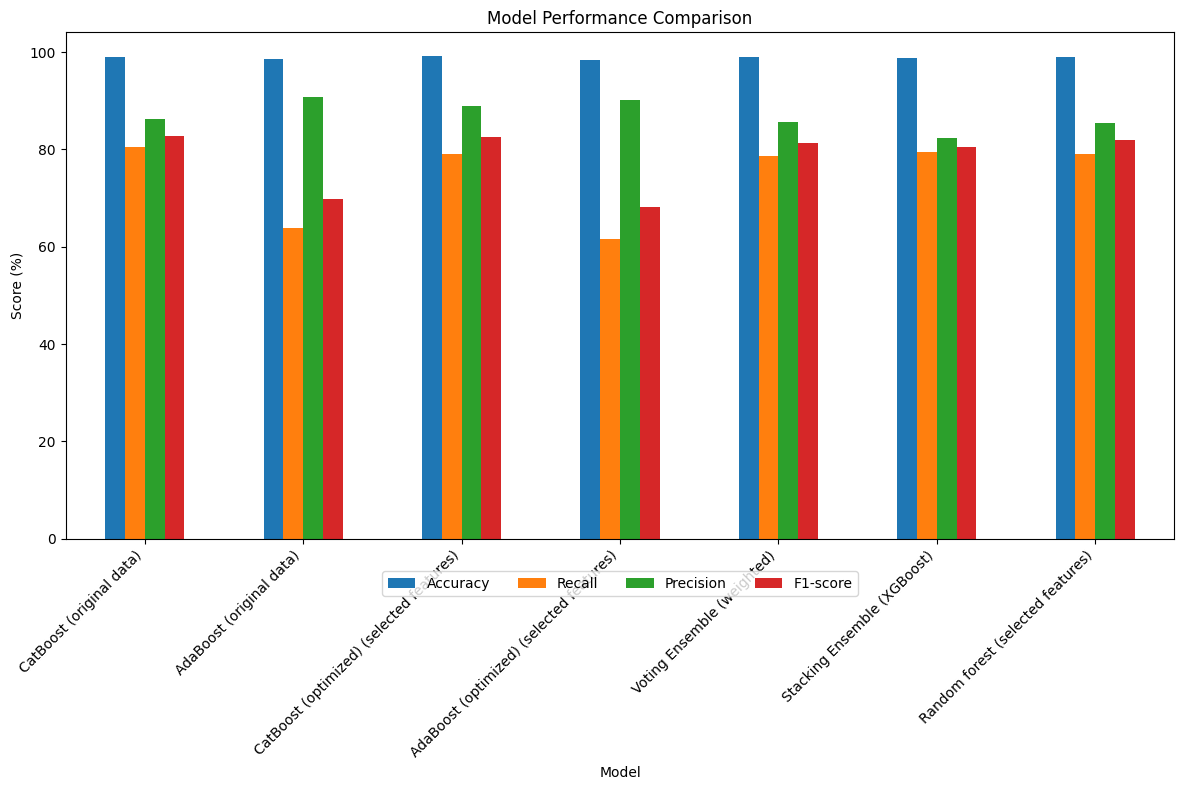

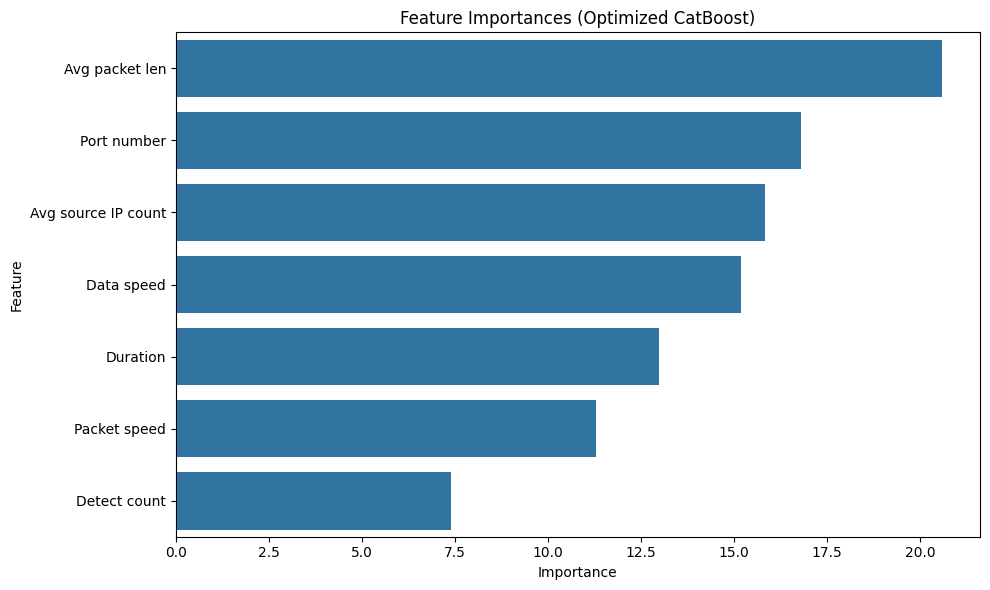


Best models saved to disk.

Completed feature selection, model optimization, and ensemble creation.


In [44]:
# Create results DataFrame
results_df = pd.DataFrame(results).T
print("\n=== Final Comparison ===")
print(results_df)

# Visualize results
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score (%)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.savefig('model_comparison.png')
plt.show()

# Get feature importance from the best model (CatBoost)
catboost_optimized.fit(X_train, y_train)
feature_importances = catboost_optimized.get_feature_importance()
feature_names = X_train.columns

# Create and plot feature importance DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances (Optimized CatBoost)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Save the best models
import joblib
joblib.dump(best_catboost, 'best_catboost_model.pkl')
joblib.dump(best_adaboost, 'best_adaboost_model.pkl')
joblib.dump(meta_learner, 'stacking_meta_learner.pkl')

print("\nBest models saved to disk.")
print("\nCompleted feature selection, model optimization, and ensemble creation.")

# Return the final selected features for documentation
# print("\nFinal selected features for CatBoost:")
# print(catboost_selected_features)
# print("\nFinal selected features for RFECV:")
# print(rfecv_selected_features)

In [45]:
test_df = df_D_events
X_test_general = test_df[features]
y_test_general = test_df["Type"]

In [46]:
catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train, y_train, X_test_general, y_test_general,
    "CatBoost", "original data"
)
ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train, y_train, X_test_general, y_test_general,
    "AdaBoost", "original data"
)
catboost_optimized, y_pred_cat_opt, conf_cat_opt = evaluate_model(
    best_catboost, X_train, y_train, X_test_general, y_test_general,
    "CatBoost (optimized)", "selected features"
)

adaboost_optimized, y_pred_ada_opt, conf_ada_opt = evaluate_model(
    best_adaboost, X_train, y_train, X_test_general, y_test_general,
    "AdaBoost (optimized)", "selected features"
)
randomforest, y_pred_rf, conf_rf = evaluate_model(
    rf, X_train, y_train, X_test_general, y_test_general,
    "Random forest", "selected features"
)
voting_preds, voting_conf = create_voting_ensemble(
    X_train, X_train,
    X_test_general, X_test_general,
    y_train, y_test_general
)

stacking_preds, stacking_conf, meta_learner = create_stacking_ensemble(
    X_train, X_train,
    X_test_general, X_test_general,
    y_train, y_test_general
)

CatBoost with original data
Accuracy: 0.9224, Recall: 0.5905, Precision: 0.7378, F1-score: 0.6299
Confusion Matrix:
[[  9494   4981    258]
 [   139 390289   4054]
 [  2192  22317   3915]]
AdaBoost with original data
Accuracy: 0.9176, Recall: 0.4425, Precision: 0.7877, F1-score: 0.4939
Confusion Matrix:
[[  2344   6458   5931]
 [     0 394451     31]
 [    27  23612   4785]]
CatBoost (optimized) with selected features
Accuracy: 0.9173, Recall: 0.5432, Precision: 0.7292, F1-score: 0.5906
Confusion Matrix:
[[  8330   6200    203]
 [    63 391051   3368]
 [   912  25439   2073]]


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (optimized) with selected features
Accuracy: 0.9400, Recall: 0.5974, Precision: 0.8655, F1-score: 0.6772
Confusion Matrix:
[[  5664   3289   5780]
 [     0 394105    377]
 [    49  16757  11618]]
Random forest with selected features
Accuracy: 0.9174, Recall: 0.5479, Precision: 0.7342, F1-score: 0.5970
Confusion Matrix:
[[  8320   6284    129]
 [    68 390640   3774]
 [  1021  24885   2518]]

=== Creating Voting Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Voting Ensemble (weighted probabilities)
Accuracy: 0.9175, Recall: 0.5433, Precision: 0.7316, F1-score: 0.5912
Confusion Matrix:
[[  8324   6176    233]
 [    58 391117   3307]
 [   879  25458   2087]]

=== Creating Stacking Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Stacking Ensemble (XGBoost meta-learner)
Accuracy: 0.9184, Recall: 0.5706, Precision: 0.7084, F1-score: 0.6061
Confusion Matrix:
[[  9191   5329    213]
 [   442 389927   4113]
 [  1866  23732   2826]]



=== Final Comparison ===
                                          Accuracy  Recall  Precision  \
CatBoost (original data)                     92.24   59.05      73.78   
AdaBoost (original data)                     91.76   44.25      78.77   
CatBoost (optimized) (selected features)     91.73   54.32      72.92   
AdaBoost (optimized) (selected features)     94.00   59.74      86.55   
Voting Ensemble (weighted)                   91.75   54.33      73.16   
Stacking Ensemble (XGBoost)                  91.84   57.06      70.84   
Random forest (selected features)            91.74   54.79      73.42   

                                          F1-score  
CatBoost (original data)                     62.99  
AdaBoost (original data)                     49.39  
CatBoost (optimized) (selected features)     59.06  
AdaBoost (optimized) (selected features)     67.72  
Voting Ensemble (weighted)                   59.12  
Stacking Ensemble (XGBoost)                  60.61  
Random forest (sel

<Figure size 1200x800 with 0 Axes>

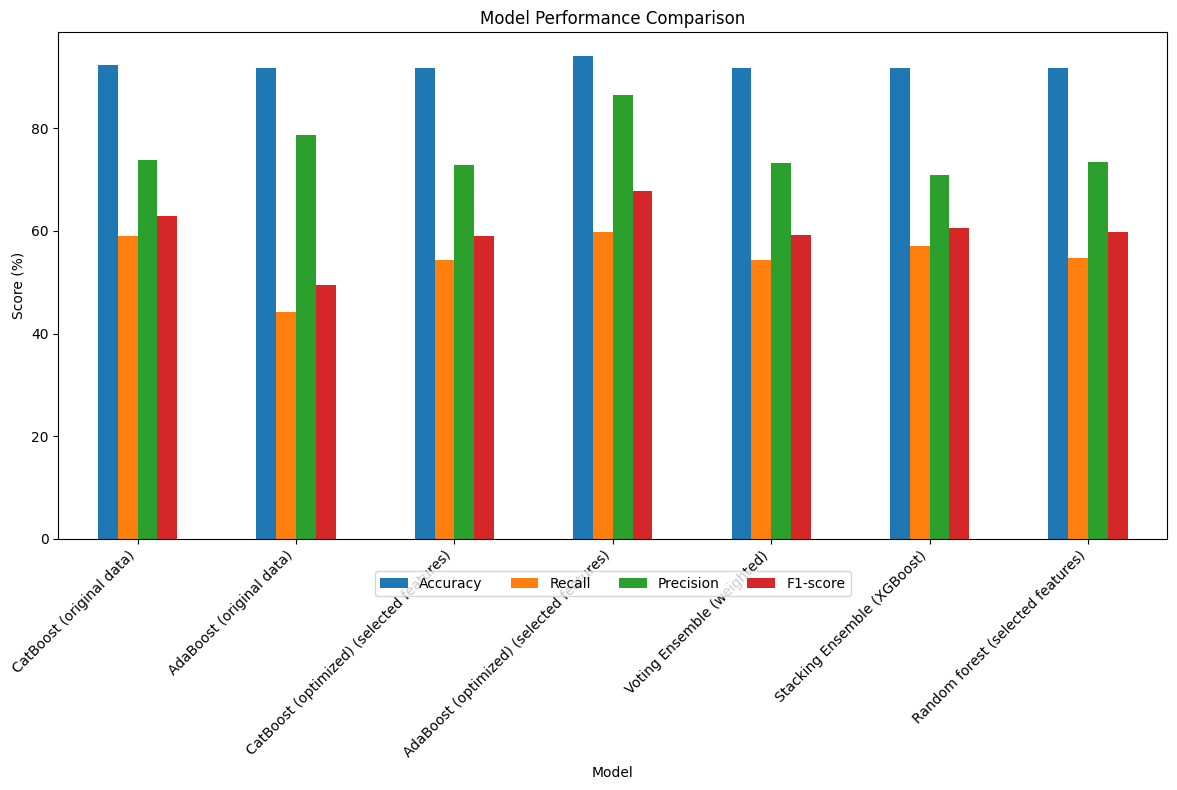

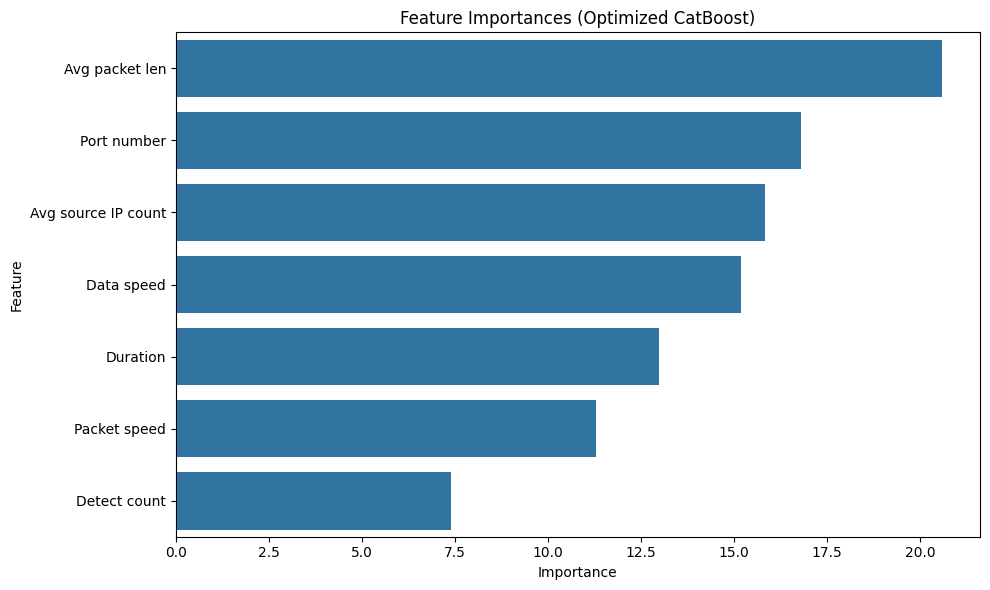


Best models saved to disk.

Completed feature selection, model optimization, and ensemble creation.


In [47]:
# Create results DataFrame
results_df = pd.DataFrame(results).T
print("\n=== Final Comparison ===")
print(results_df)

# Visualize results
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score (%)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.savefig('model_comparison.png')
plt.show()

# Get feature importance from the best model (CatBoost)
catboost_optimized.fit(X_train, y_train)
feature_importances = catboost_optimized.get_feature_importance()
feature_names = X_train.columns

# Create and plot feature importance DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances (Optimized CatBoost)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Save the best models
import joblib
joblib.dump(best_catboost, 'best_catboost_model.pkl')
joblib.dump(best_adaboost, 'best_adaboost_model.pkl')
joblib.dump(meta_learner, 'stacking_meta_learner.pkl')

print("\nBest models saved to disk.")
print("\nCompleted feature selection, model optimization, and ensemble creation.")